# Theoritical Guidelines

### Article analysis:  [A framework for Multi-A(rmed)/B(andit) testing with online FDR control](https://arxiv.org/pdf/1706.05378.pdf)
#### Authors: Hugo MALLET, Mithuran GAJENDRAN

## Aim

The aim of this material is to implement a base model of Multi-Armed-Bandits for our own educational purposes.

## Imports

In [1]:
# Imports

%matplotlib notebook

import sys
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
#np.random.seed(42)

### Introduction

We conducted our analysis over the following article: ["A framework for Multi-A(rmed)/B(andit) testing with online FDR control"](https://arxiv.org/pdf/1706.05378.pdf). In short, it summarizes how to optimize the use of p-values to reject or not ""discoveries" done through A/B testing.

During this analysis, Multi-Armed-Bandits algorithms caught our interest, and we wanted to implement one for educational purposes.

In order to give this implementation a practical point of view, let's define a use-case:
* Compagny A sells cars to customers through their online website.
* Compagny A knows by experience the user interface of the website infers on the customers buying behavior
* Compagny A defined a metric: Click-to-buy ratio and wants to **maximize it**
* Compagny A has designed 4 websites to test.

The traditional testing would be **A/B testing**. For a fixed period of time (fixed according to the p-value signifiance), each website channel gets randomly attributed customers. Here, compagny A will be focusing on the Click-to-buy statistics and find the best channel for the sells. Afterward, company A will be releasing the best website channel to all of its customers. *A/B testing is therefore pure exploration*

However, this is not an optimal solution as **A/B testing requires a fixed period time**:
* Compagny A during the time of the testing **won't be able to maximize it gains**
* Customer **trends might change** before, during, and after the experiment making it unsuccesfull. 

Therefore, one should seek for an *exploration-exploitation solution*, a solution that exploit the result of its exploitation while testing. 

Multi-armed-bandit (MAB) testing has no fixed period of time, nor fixed size customer random attribution. This algorithm will start optimizing the Click-to-buy ratio from the very start. We will be defining a basic form of this algorithm with Thompson sampling (which is reconned to be working really well) through this material.





### Building our Bandit

Building our bandit is astonighingly simple when the concept is clear. Our bandit has tree main variables:
* the probability to be choosen
* the number of trials
* the number of wins

The customers Click-to-buy rate will be modelized by Bernoulli distribution. The customer either buys or not the car. For our class Bandit, this is permitted through the pull method. The goal is to find the best probability rate: here,the higher the probability, the better the sales of a certain channel.

In other words, this is Bayesian inference: $P(win| p_{bandit}) = \frac{P(p_{bandit}|win)\times P(win)}{P(p_{bandit})}$ and we we want to extract the posterior distriution of $p_{bandit}$ which results in 
<br><br>

<center> $P(p_{bandit}| win) = \frac{P(win|p_{bandit})\times P(p_{bandit})}{P(win)}$ </center>

* $P(win| p_{bandit})$ follows the Bernoulli distribution aforementionned
* $P(win)$ will be calculated through the sum of wins and trials
* $P(p_{bandit})$ is the prior and will be calcuated using the Beta prior as it is the conjugate of Bernouilli's. More information can be found [here](http://www2.stat.duke.edu/~rcs46/modern_bayes17/lecturesModernBayes17/lecture-1/01-intro-to-Bayes.pdf)

Finally, this algorithm works iteratively. While performing exploitation-exploration, the bandit will be converging to the "highest" bandit with the highest certain probability as it will have tried more often the "highest" bandit. This also means, that an "unlucky" bandit starting with losses at the beginning of the maximization would get penalized, have not enough momentum to come back into the race. This issue could be annoying if the "unlucky" bandit turned out to be the "real highest" bandit. 

To tackle this issue, we will be using the **Thompson sampling** on $P(p_{bandit})$. As the "unlucky" has a higher variance than the "highest" bandit, with iteration it can come back as the "real highest" bandit. In other words, **Thompson sampling adds some randomness in the bandits to avoid local maximums.**

In [2]:
class Bandit:
    def __init__(self, p_bandit):
        self.p_bandit = p_bandit
        self.trial = 0
        self.win = 0
        
    def pull(self):
        self.trial += 1
        if np.random.rand() < self.p_bandit:
            self.win +=1
        
    def rdm_trend_change(self):
        self.p_bandit = np.random.rand()
        
    def trend_change(self,p):
        self.p_bandit = p

In [3]:
class Environment:
    
    def __init__(self, l_bandits, n_subplots=10, n=1000):
        
        self.l_bandits = l_bandits
        self.n = n
        if self.n >= n_subplots:
            self.n_subplots = n_subplots
        else:
            print("Error n < n_subplots")
        self.plots = np.linspace(0, self.n,n_subplots , endpoint=True, dtype=int)
    
    def plot(self,priors, step, ax):
        # Plot priors at step
        plot_x = np.linspace(0.0001, .999, 100)
        for prior in priors:
            y = prior.pdf(plot_x)
            p = ax.plot(plot_x, y)
            ax.fill_between(plot_x, y, 0, alpha=0.2)
        ax.set_xlim([0, 1])
        ax.set_ylim(bottom=0)
        ax.set_title(f'Priors at step {step:d}')
        
    def shuffle_bandits(self):
        l_tmp = [ el.p_bandit for el in self.l_bandits]
        np.random.shuffle(l_tmp)
        for i_el in range(len(self.l_bandits)):
            self.l_bandits[i_el].p_bandit = l_tmp[i_el]        
        
    def run(self,trend=""):
        
        # fix nb of plots
        fig, axs = plt.subplots(self.n_subplots//2, 2, figsize=(8, 10))
        axs = axs.flat
        # Run the algorithm n times
        for step in range(self.n+1):
            
            # add scenarios 
            
            if trend == "shuffle":
                # p_bandit of bandits are swapped: intersting for political behavior 
                if step == np.random.randint(self.n):
                    old_ps = [ el.p_bandit for el in self.l_bandits]
                    self.shuffle_bandits()
                    print("Step %s ,old ps: %s , new ps: %s" %(step, old_ps, [ el.p_bandit for el in self.l_bandits]))
            
            elif trend == "cyclic":
                # p_bandit of bandits are swapped each 5000:
                if step%500 ==0:
                    old_ps = [ el.p_bandit for el in self.l_bandits]
                    self.shuffle_bandits()
                    print("Step %s ,old ps: %s , new ps: %s" %(step, old_ps, [ el.p_bandit for el in self.l_bandits]))
           

            elif trend == "rdm":
                # one bandits p_bandit is changed randomly
                if step == np.random.randint(self.n):
                    el_choice = np.random.randint(len(l_bandits))
                    old_p = l_bandits[el_choice].p_bandit
                    l_bandits[el_choice].rdm_trend_change()
                    print("Step %s , Bandit %s old p: %s , new p: %s" %(step,el_choice, old_p, l_bandits[el_choice].p_bandit))
                    
                    
            elif (trend == ""):
                #change a bandits p_bandit at a step with new p_bandit if well specified e.g."200-3-0.1"
                # if "" then nothing
                try:
                    change_at, n_bandit, new_p = [float(el) for el in trend.split('-')]
                    if step == change_at:
                        print("Step %s , Bandit %s old p: %s , new p: %s" %(step,int(n_bandit), l_bandits[int(n_bandit)].p_bandit, new_p))
                        l_bandits[int(n_bandit)].trend_change(new_p)
                except:
                    pass

                    

            # Update prior with current observations BETA prior
            bandit_priors = [stats.beta(a=1+el.win, b=1+el.trial-el.win) for el in l_bandits]
            # plot
            if step in self.plots:
                self.plot(bandit_priors, step, next(axs))
            # Thompson sampling of p_bandit for each bandit
            theta_samples = [d.rvs(1) for d in bandit_priors]
            # Get "highest" bandit
            chosen_bandit = np.argmax(theta_samples)
            # Pull the bandit arm to activate Bernouilli distribution
            l_bandits[chosen_bandit].pull()
            
        plt.tight_layout()
        plt.show()

Now that the algorithm is built, let's try it:
* Create the bandits with nearby probabilities of winning
* Create bandits with one clear winner 

*Click on the standby button to stop the memory restraint*

In [4]:
b1 = Bandit(0.3)
b2 = Bandit(0.1)
b3 = Bandit(0.2)
b4 = Bandit(0.4) # red bandit
l_bandits = [b1,b2,b3,b4]

<IPython.core.display.Javascript object>


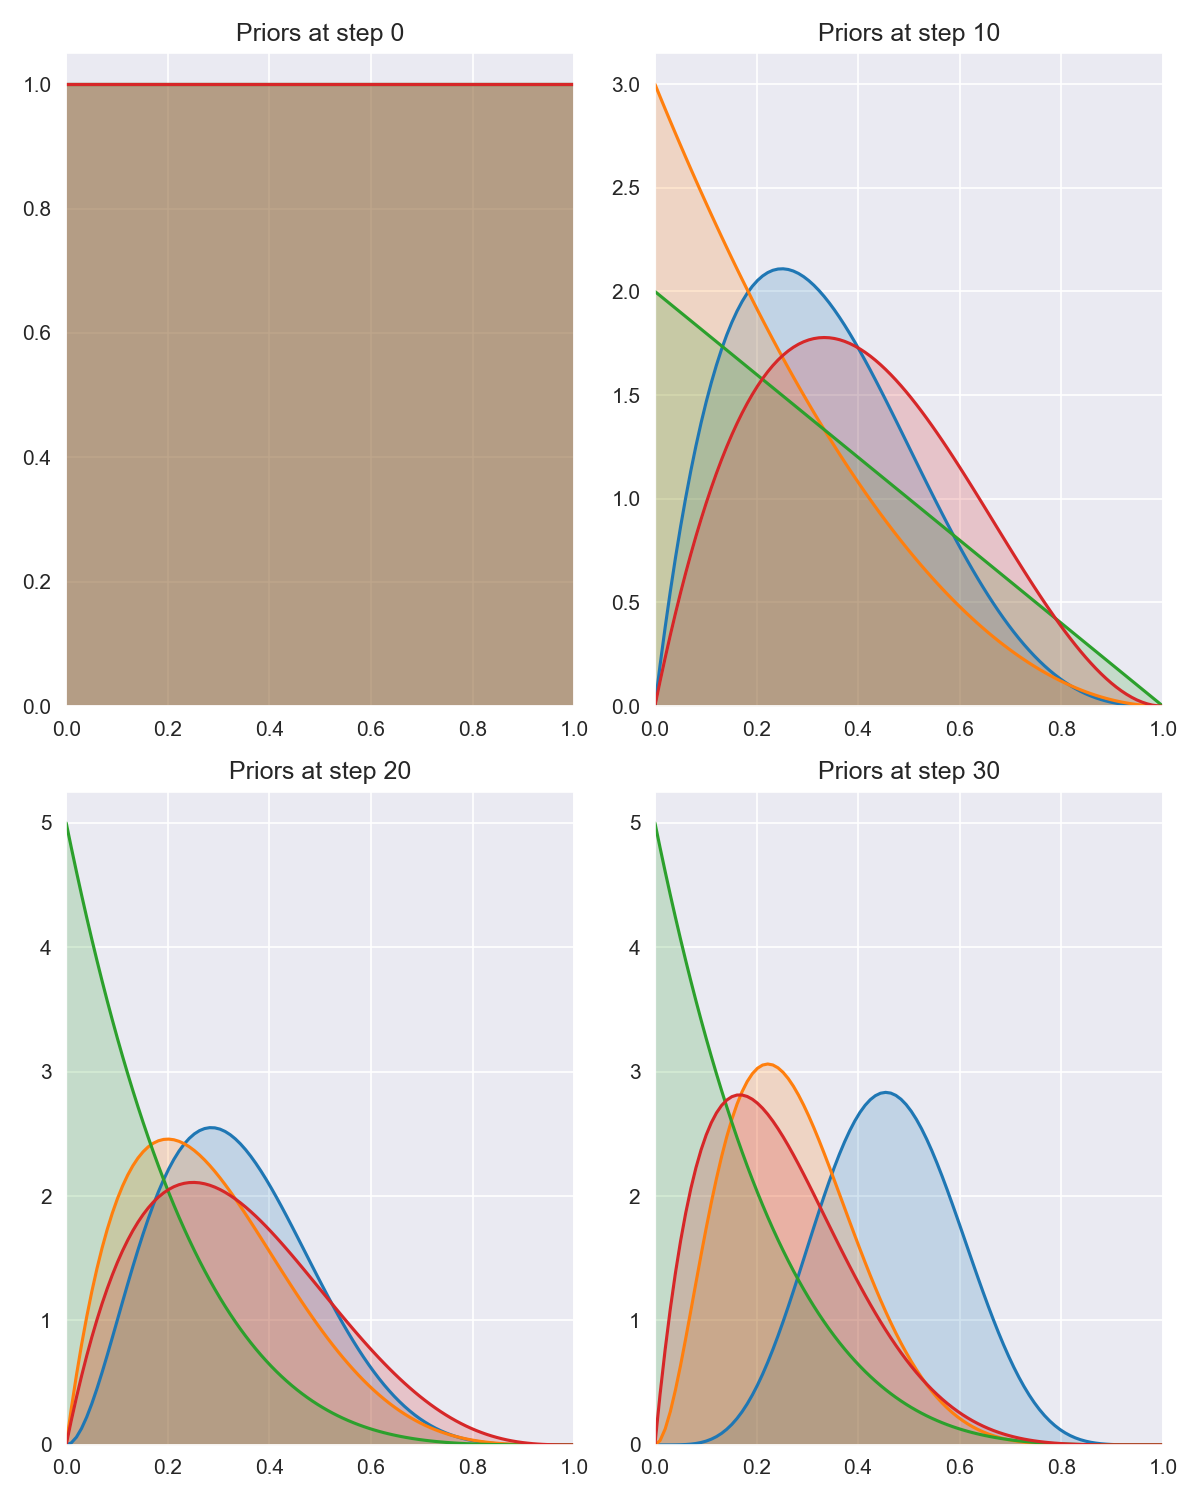

In [5]:
Environment(l_bandits, n_subplots=4, n=30).run("")

For a small, amount of iteration we can see that the red bandit (the real highest bandit) is not always winning. However, this is not the case when there is one clear winning bandit: 

<IPython.core.display.Javascript object>


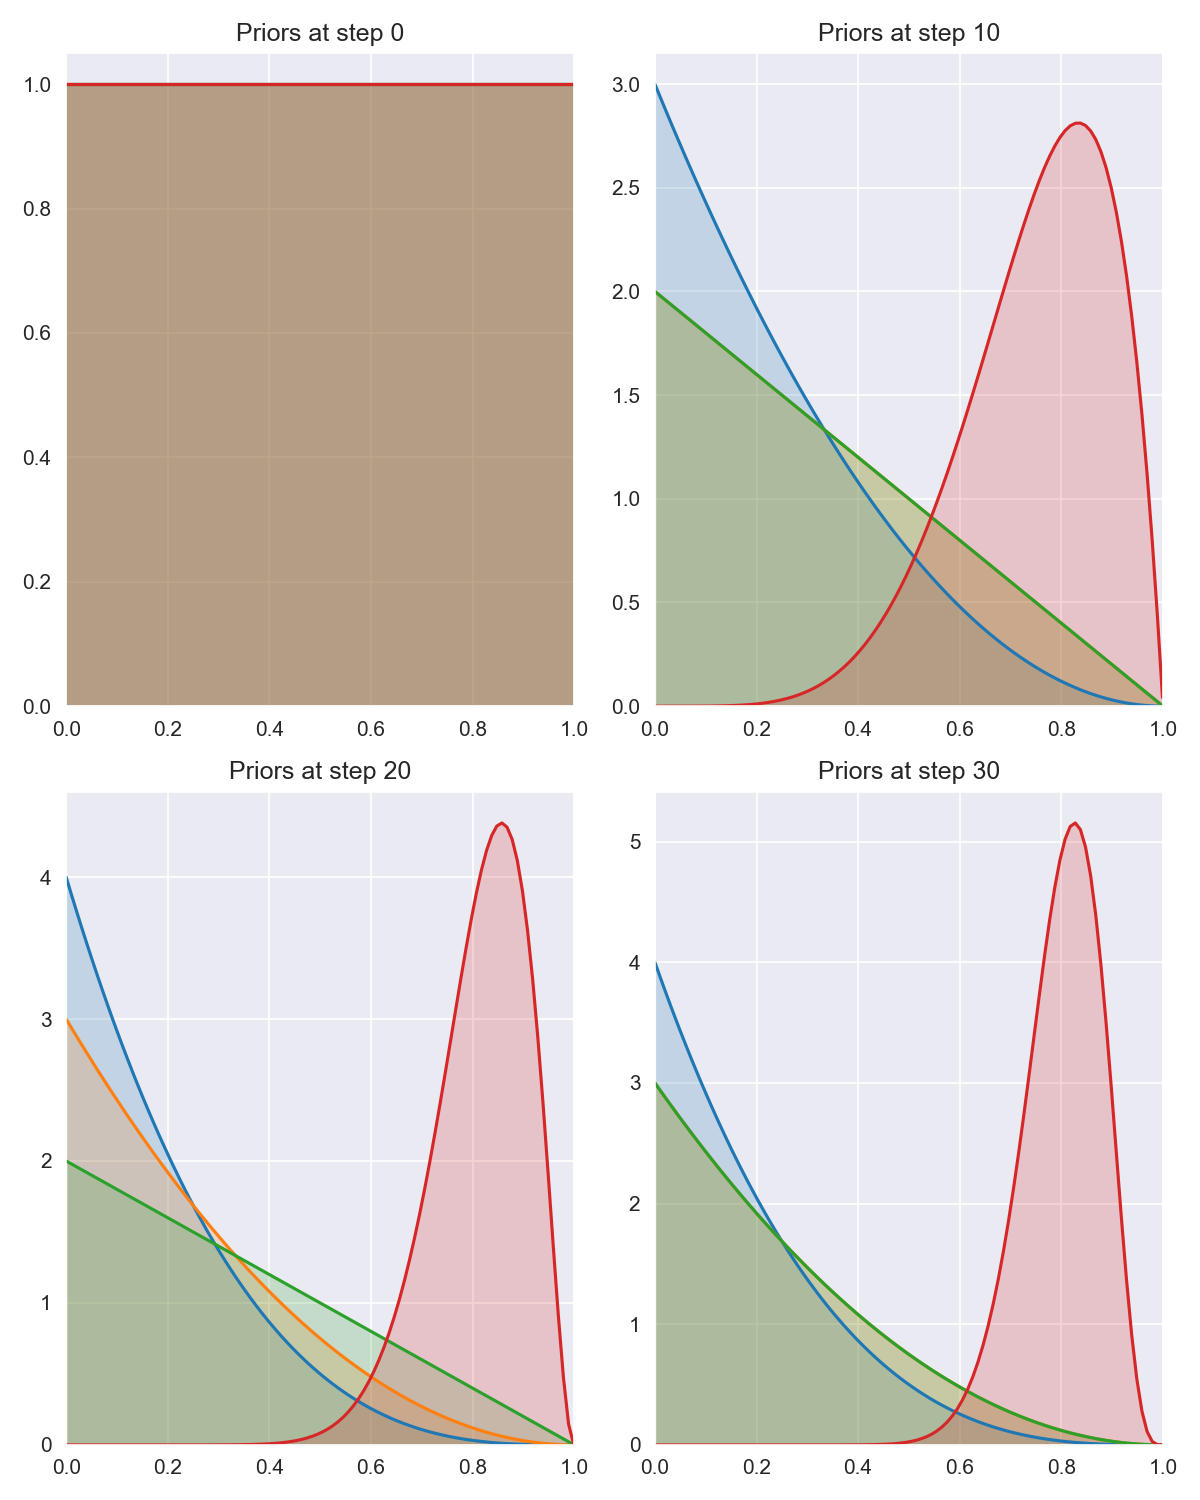

In [6]:
b1 = Bandit(0.3)
b2 = Bandit(0.1)
b3 = Bandit(0.2)
b4 = Bandit(0.8)
l_bandits = [b1,b2,b3,b4]
Environment(l_bandits, n_subplots=4, n=30).run("")

This first simulations clearly show us that n, the number of iterations has to be tuned in a less basic form of our algorithm to make it converge.

The next simulation is pretty interesting: it convinced us that MAB selects the best "arm". This could be interpreted as customers changing trends for buying.

<IPython.core.display.Javascript object>


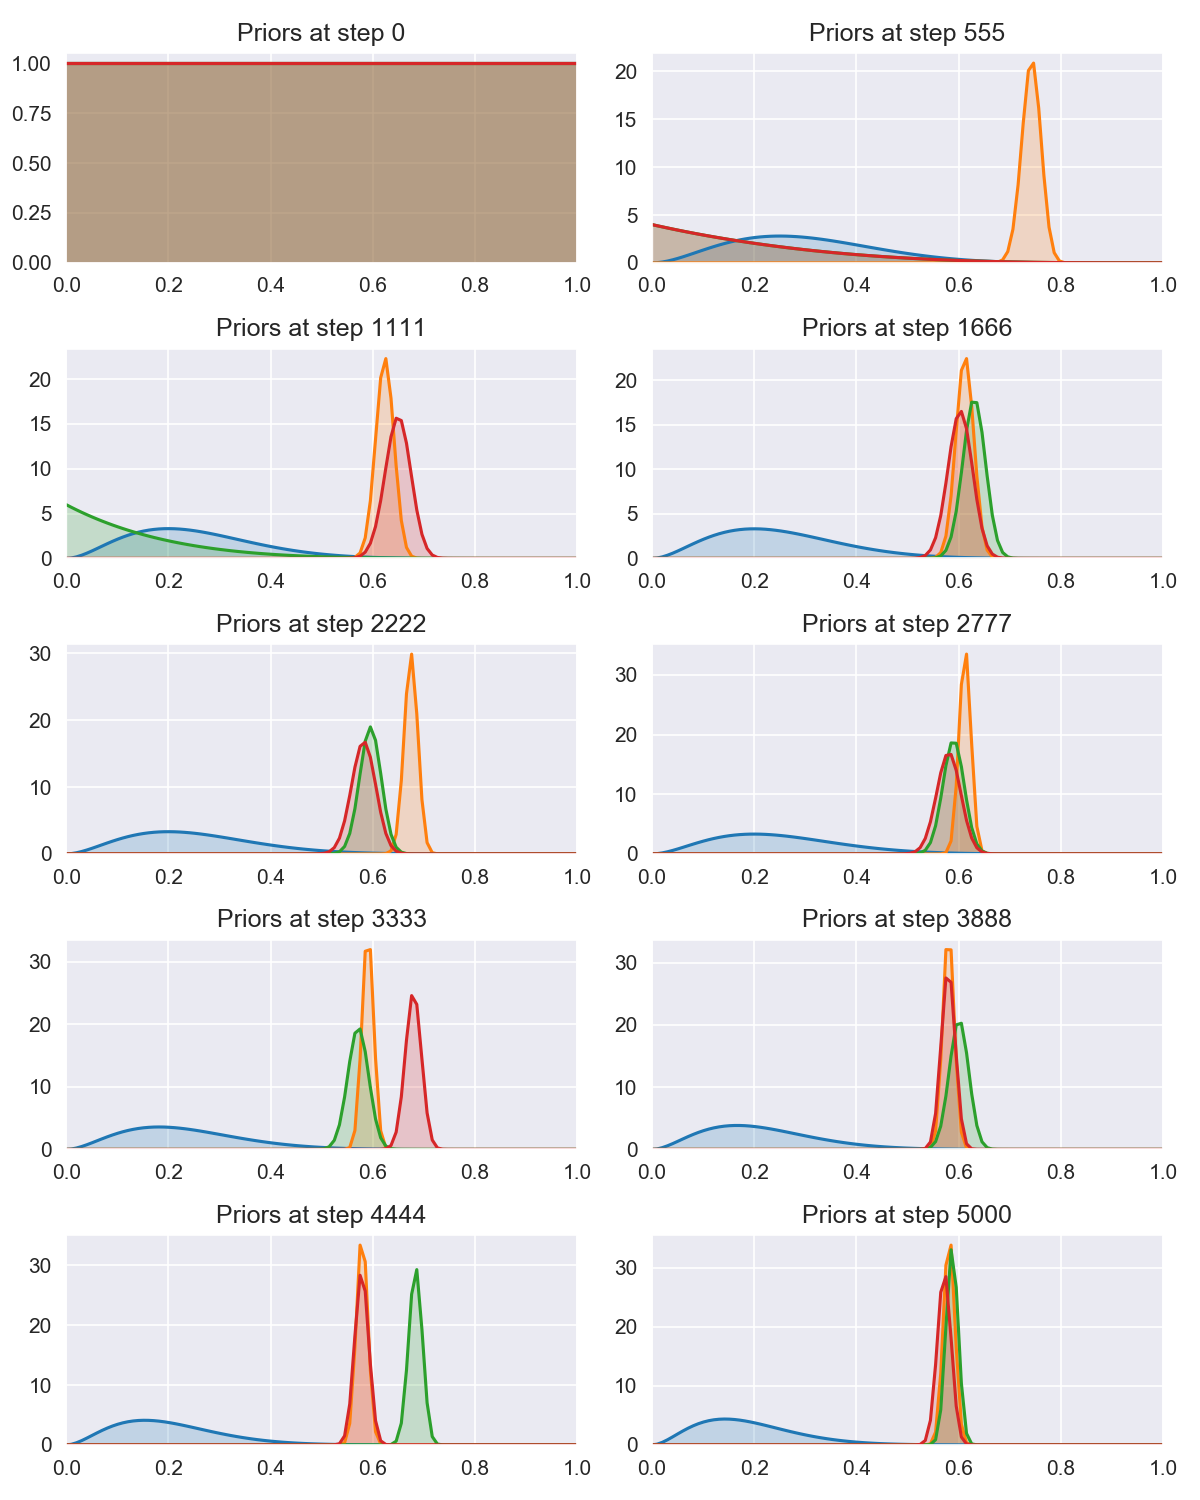

Step 0 ,old ps: [0.3, 0.1, 0.2, 0.8] , new ps: [0.3, 0.8, 0.2, 0.1]
Step 500 ,old ps: [0.3, 0.8, 0.2, 0.1] , new ps: [0.1, 0.3, 0.2, 0.8]
Step 1000 ,old ps: [0.1, 0.3, 0.2, 0.8] , new ps: [0.1, 0.2, 0.8, 0.3]
Step 1500 ,old ps: [0.1, 0.2, 0.8, 0.3] , new ps: [0.1, 0.8, 0.3, 0.2]
Step 2000 ,old ps: [0.1, 0.8, 0.3, 0.2] , new ps: [0.3, 0.8, 0.2, 0.1]
Step 2500 ,old ps: [0.3, 0.8, 0.2, 0.1] , new ps: [0.2, 0.1, 0.3, 0.8]
Step 3000 ,old ps: [0.2, 0.1, 0.3, 0.8] , new ps: [0.1, 0.3, 0.2, 0.8]
Step 3500 ,old ps: [0.1, 0.3, 0.2, 0.8] , new ps: [0.3, 0.2, 0.8, 0.1]
Step 4000 ,old ps: [0.3, 0.2, 0.8, 0.1] , new ps: [0.3, 0.1, 0.8, 0.2]
Step 4500 ,old ps: [0.3, 0.1, 0.8, 0.2] , new ps: [0.2, 0.8, 0.3, 0.1]
Step 5000 ,old ps: [0.2, 0.8, 0.3, 0.1] , new ps: [0.1, 0.2, 0.3, 0.8]


In [7]:
b1 = Bandit(0.3)
b2 = Bandit(0.1) # orange
b3 = Bandit(0.2)
b4 = Bandit(0.8)
l_bandits = [b1,b2,b3,b4]
Environment(l_bandits, n_subplots=10, n=5000).run("cyclic")

Voici quelques autres scénarios que nous avons trouvé interéssant à tourner.

In [8]:
#Environment(l_bandits, n_subplots=10, n=1000).run("rdm")
#Environment(l_bandits, n_subplots=10, n=3000).run("200-3-0.1")
#Environment(l_bandits, n_subplots=10, n=3000).run()